In [67]:
#importing the libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder ,StandardScaler
from sklearn.compose import  ColumnTransformer
import numpy as np
from scipy import stats

In [20]:
data=pd.read_csv("Train.csv")
#gives the First 5 rows
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Handling missing value

In [22]:
#Check if there are still missing values in the data
missing_data = data.isnull().sum()

In [24]:
missing_data

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [32]:
#finding the mean of 'Item_Visibility' for entries where it is greater than 0
non_zero_mean = data.loc[data['Item_Visibility'] > 0, 'Item_Visibility'].mean()

#Filling missing Item_Weight values by grouping by Item_Type and using the median 
data['Item_Weight']=data['Item_Weight'].fillna(data.groupby('Item_Type')['Item_Weight'].transform('median'))

#Filling missing Outlet_Size values by grouping by Item_Type and using the mode 
data['Outlet_Size'] = data['Outlet_Size'].fillna(data.groupby('Item_Type')['Outlet_Size'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

# Fix inconsistencies in the 'Item_Fat_Content' column by standardizing the labels
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

In [34]:
# Checking for duplicates and removing them if any
data.drop_duplicates(inplace=True)

In [36]:
#Check if there are still missing values in the data
data_without = data.isnull().sum()

In [38]:
print(data_without)

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


##  Categorical Variable Encoding

In [41]:
# Assuming nominal and ordinal data columns
nominal_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type','Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type']  # Categorical without order
ordinal_cols = ['Outlet_Size']  # Categorical with order, e.g., Small < Medium < High
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP','Item_Outlet_Sales', 'Outlet_Establishment_Year']  # Numerical columns

# Display identified nominal and ordinal and numerical columns
print("\nNominal Columns:", nominal_cols)
print("Ordinal Columns:", ordinal_cols)
print("Numerical Columns:", numerical_columns)


Nominal Columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type']
Ordinal Columns: ['Outlet_Size']
Numerical Columns: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales', 'Outlet_Establishment_Year']


In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Convert Item_Identifier and Outlet_Identifier to numeric using Label Encoding
data['Item_Identifier'] = label_encoder.fit_transform(data['Item_Identifier'])
data['Outlet_Identifier'] = label_encoder.fit_transform(data['Outlet_Identifier'])

# Display transformed columns
data[['Item_Identifier', 'Outlet_Identifier']].head()

,Item_Identifier,Outlet_Identifier
0,156,9
1,8,3
2,662,9
3,1121,0
4,1297,1


In [45]:
data.Outlet_Size.unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [49]:
#defining mappings for Outlet_Size
map_Outlet_Size=['Medium', 'High', 'Small']

In [55]:
#applying Encoding Techniques for Columns
ohe=OneHotEncoder(sparse_output=False)      #Nominal Encoding
ode=OrdinalEncoder(categories=[map_Outlet_Size])  #Ordinal Encoding 

In [57]:
# Define the ColumnTransformer with correct transformers
ct = ColumnTransformer(
    transformers=[
        # Apply OneHotEncoder to categorical columns
        ('ohe', OneHotEncoder(sparse_output=False), 
         [ 'Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']),
        
        # Apply OrdinalEncoder to ordinal categorical columns
        ('ode', OrdinalEncoder(), ['Outlet_Size']),
    ],
   remainder='passthrough'  # Keep any other columns as they are
)
ct.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(sparse_output=False),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Location_Type', 'Outlet_Type']),
                                ('ode', OrdinalEncoder(), ['Outlet_Size'])])

In [59]:
# applying the transformation
df_encoded = ct.fit_transform(data)
df_encoded.head()


,ohe__Item_Fat_Content_Low Fat,ohe__Item_Fat_Content_Regular,ohe__Item_Type_Baking Goods,ohe__Item_Type_Breads,ohe__Item_Type_Breakfast,ohe__Item_Type_Canned,ohe__Item_Type_Dairy,ohe__Item_Type_Frozen Foods,ohe__Item_Type_Fruits and Vegetables,ohe__Item_Type_Hard Drinks,...,ohe__Outlet_Type_Supermarket Type2,ohe__Outlet_Type_Supermarket Type3,ode__Outlet_Size,remainder__Item_Identifier,remainder__Item_Weight,remainder__Item_Visibility,remainder__Item_MRP,remainder__Outlet_Identifier,remainder__Outlet_Establishment_Year,remainder__Item_Outlet_Sales
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,156,9.30,0.016047,249.8092,9,1999,3735.1380
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,8,5.92,0.019278,48.2692,3,2009,443.4228
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,662,17.50,0.016760,141.6180,9,1999,2097.2700
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1121,19.20,0.000000,182.0950,0,1998,732.3800
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1297,8.93,0.000000,53.8614,1,1987,994.7052


In [61]:
# Renaming columns
new_column_names = {'remainder__Item_Identifier':'Item_Identifier' ,
       'ohe__Item_Fat_Content_Low Fat':'Item_Fat_Content_Low Fat',
       'ohe__Item_Fat_Content_Regular':'Item_Fat_Content_Regular',
       'remainder__Outlet_Identifier':'Outlet_Identifier',
       'ohe__Item_Type_Baking Goods':'Item_Type_Baking Goods', 
       'ohe__Item_Type_Breads':'Item_Type_Breads',
       'ohe__Item_Type_Breakfast':'Item_Type_Breakfast', 
       'ohe__Item_Type_Canned':'Item_Type_Canned',
       'ohe__Item_Type_Dairy':'Item_Type_Dairy',
       'ohe__Item_Type_Frozen Foods':'Item_Type_Frozen Foods',
       'ohe__Item_Type_Fruits and Vegetables':'Item_Type_Fruits and Vegetables',
        'ohe__Item_Type_Hard Drinks':'Item_Type_Hard Drinks',
       'ohe__Item_Type_Health and Hygiene':'Item_Type_Health and Hygiene', 
        'ohe__Item_Type_Household':'Item_Type_Househol',
       'ohe__Item_Type_Meat':'Item_Type_Meat', 
        'ohe__Item_Type_Others':'Item_Type_Others',
       'ohe__Item_Type_Seafood':'Item_Type_Seafood',
        'ohe__Item_Type_Snack Foods':'Item_Type_Snack Foods',
       'ohe__Item_Type_Soft Drinks':'Item_Type_Soft Drink',
       'ohe__Item_Type_Starchy Foods' :'Item_Type_Starchy Foods',
       'ohe__Outlet_Location_Type_Tier 1':'Outlet_Location_Type_Tier 1',
        'ohe__Outlet_Location_Type_Tier 2':'Outlet_Location_Type_Tier 2',
       'ohe__Outlet_Location_Type_Tier 3':'Outlet_Location_Type_Tier 3', 
        'ohe__Outlet_Type_Grocery Store':'Outlet_Type_Grocery Store',
       'ohe__Outlet_Type_Supermarket Type1':'Outlet_Type_Supermarket Type1',
       'ohe__Outlet_Type_Supermarket Type2':'Outlet_Type_Supermarket Type2',
       'ohe__Outlet_Type_Supermarket Type3':'Outlet_Type_Supermarket Type3', 
       'ode__Outlet_Size':'Outlet_Size',
       'remainder__Item_Weight': 'Item_Weight',
       'remainder__Item_Visibility':'Item_Visibility',
       'remainder__Item_Outlet_Sales':'Item_Outlet_Sales',
       'remainder__Item_MRP':'Item_MRP',
       'remainder__Outlet_Establishment_Year':'Outlet_Establishment_Year' ,
       }
# Apply the renaming
df_encoded.rename(columns=new_column_names, inplace=True)

df_encoded.head(5)


,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,156,9.30,0.016047,249.8092,9,1999,3735.1380
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,8,5.92,0.019278,48.2692,3,2009,443.4228
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,662,17.50,0.016760,141.6180,9,1999,2097.2700
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1121,19.20,0.000000,182.0950,0,1998,732.3800
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1297,8.93,0.000000,53.8614,1,1987,994.7052


## Feature Derivation

In [64]:
# Feature Derivation: Creating a new feature for the store's age
data['Outlet_Age'] = 2024 - data['Outlet_Establishment_Year']

data[['Outlet_Establishment_Year', 'Outlet_Age']].head()

,Outlet_Establishment_Year,Outlet_Age
0,1999,25
1,2009,15
2,1999,25
3,1998,26
4,1987,37


## OUTLIER TREATMENT

Using Z-Score Method

Item_Weight: 0 outliers detected.
Item_Visibility: 146 outliers detected.
Item_MRP: 0 outliers detected.
Item_Outlet_Sales: 197 outliers detected.


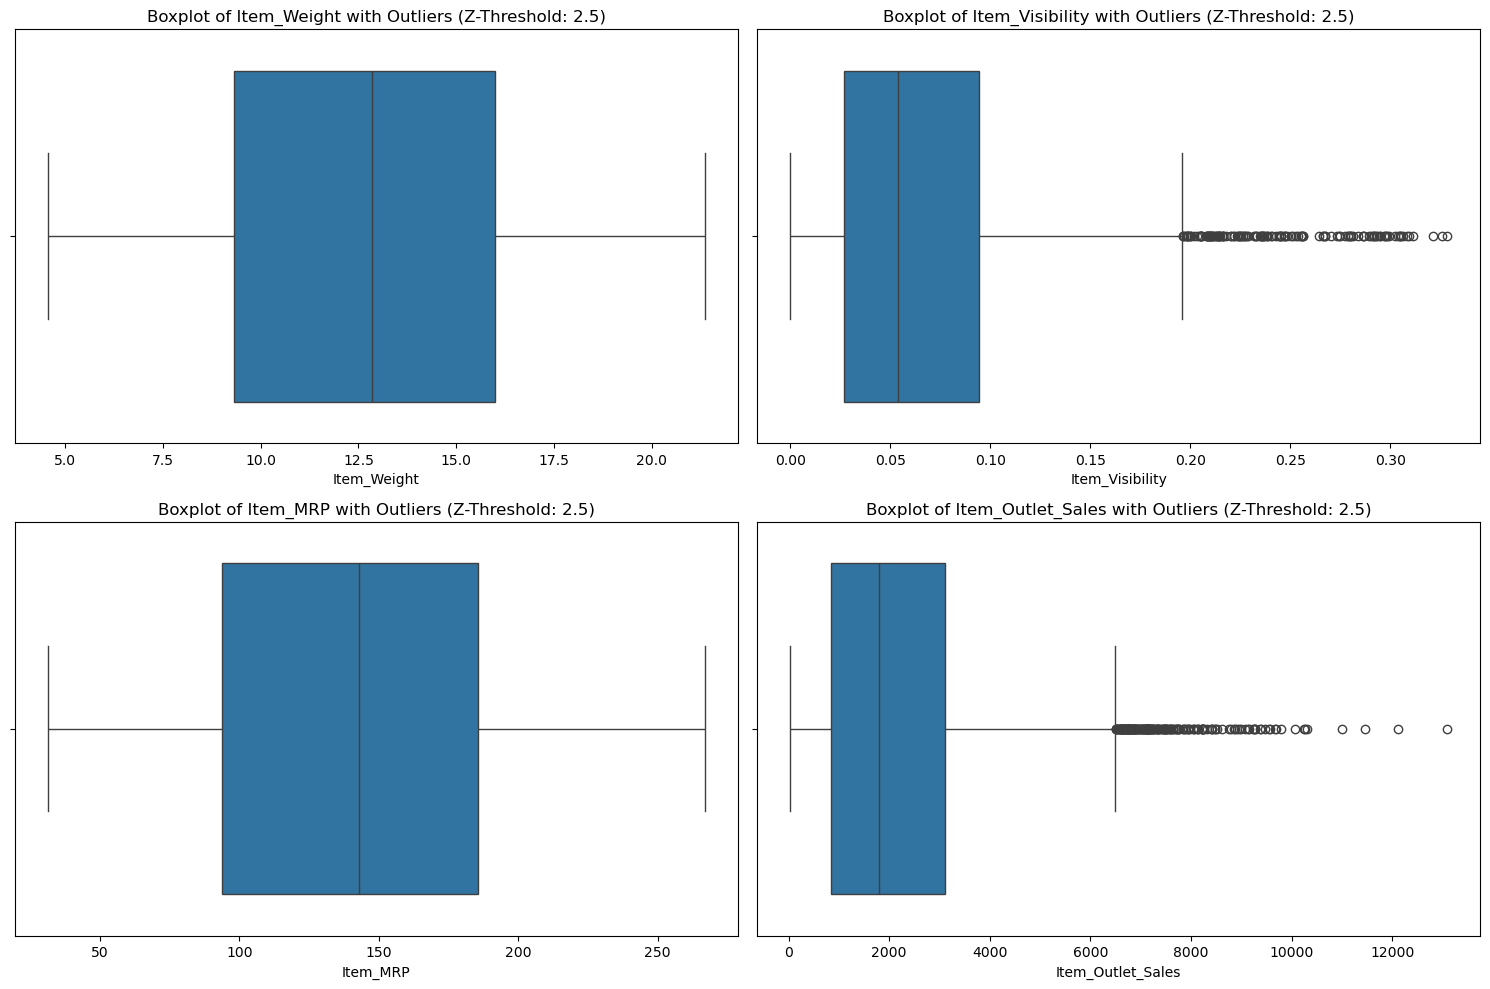

In [70]:
# continuous numerical features
continuous_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

# Z-score threshold
z_threshold = 2.5  # as 3 results with 0 outliers & 2 with many so fixed T as 2.5

# outliers based on Z-score for each column
outliers_dict = {}
for col in continuous_columns:
    
    # Z-Score calculation
    data[col + '_zscore'] = np.abs((data[col] - data[col].mean()) / data[col].std())
    
    # outliers where Z-score is greater than threshold
    outliers_dict[col] = data[data[col + '_zscore'] > z_threshold]
    
    # Printing outlier count
    print(f"{col}: {outliers_dict[col].shape[0]} outliers detected.")

plt.figure(figsize=(15, 10))

for i, col in enumerate(continuous_columns, 1):
    plt.subplot(2, 2, i)  # Creating a 2x2 grid of plots
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col} with Outliers (Z-Threshold: {z_threshold})')

plt.tight_layout()
plt.show()

In [72]:
# Removing rows where Z-score for 'Item_Outlet_Sales' is greater than the threshold
z_threshold = 2.5
outliers_removed = data[data['Item_Outlet_Sales_zscore'] <= z_threshold]

print(f"Original dataset size: {data.shape}")
print(f"Dataset size after removing outliers: {outliers_removed.shape}")

Original dataset size: (8523, 17)
Dataset size after removing outliers: (8326, 17)


Using IQR Method

In [75]:
''' 
outliers_dict_iqr = {}
for col in continuous_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Defining bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Outliers where values are below lower_bound or above upper_bound
    outliers_dict_iqr[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    # Printing outlier count
    print(f"{col}: {outliers_dict_iqr[col].shape[0]} outliers detected using IQR.")

# Removing outliers using IQR for 'Item_Outlet_Sales'
outliers_removed_iqr = data[~((data['Item_Outlet_Sales'] < (data['Item_Outlet_Sales'].quantile(0.25) - 1.5 * (data['Item_Outlet_Sales'].quantile(0.75) - data['Item_Outlet_Sales'].quantile(0.25)))) | 
                             (data['Item_Outlet_Sales'] > (data['Item_Outlet_Sales'].quantile(0.75) + 1.5 * (data['Item_Outlet_Sales'].quantile(0.75) - data['Item_Outlet_Sales'].quantile(0.25)))))]
print(f"Dataset size after removing outliers (IQR): {outliers_removed_iqr.shape}")

'''

' \noutliers_dict_iqr = {}\nfor col in continuous_columns:\n    Q1 = data[col].quantile(0.25)\n    Q3 = data[col].quantile(0.75)\n    IQR = Q3 - Q1\n    \n    # Defining bounds for outliers\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    \n    # Outliers where values are below lower_bound or above upper_bound\n    outliers_dict_iqr[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]\n    \n    # Printing outlier count\n    print(f"{col}: {outliers_dict_iqr[col].shape[0]} outliers detected using IQR.")\n\n# Removing outliers using IQR for \'Item_Outlet_Sales\'\noutliers_removed_iqr = data[~((data[\'Item_Outlet_Sales\'] < (data[\'Item_Outlet_Sales\'].quantile(0.25) - 1.5 * (data[\'Item_Outlet_Sales\'].quantile(0.75) - data[\'Item_Outlet_Sales\'].quantile(0.25)))) | \n                             (data[\'Item_Outlet_Sales\'] > (data[\'Item_Outlet_Sales\'].quantile(0.75) + 1.5 * (data[\'Item_Outlet_Sales\'].quantile(0.75) - data[\'Item_Outlet_Sales\'

In [77]:
# Assuming 'outliers_removed' is cleaned dataset

scaled_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

# standardizing the columns
scaler = StandardScaler()
outliers_removed[scaled_columns] = scaler.fit_transform(outliers_removed[scaled_columns])

outliers_removed.head()

C:\Users\sayan\AppData\Local\Temp\ipykernel_4604\3226227457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_removed[scaled_columns] = scaler.fit_transform(outliers_removed[scaled_columns])


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Weight_zscore,Item_Visibility_zscore,Item_MRP_zscore,Item_Outlet_Sales_zscore
0,156,-0.823778,Low Fat,-0.971109,Dairy,1.800763,9,1999,Medium,Tier 1,Supermarket Type1,1.122235,25,0.828359,0.970675,1.747351,0.910548
1,8,-1.615975,Regular,-0.908784,Soft Drinks,-1.476024,3,2009,Medium,Tier 3,Supermarket Type2,-1.074526,15,1.625269,0.908058,1.488936,1.018381
2,662,1.098121,Low Fat,-0.957359,Meat,0.041710,9,1999,Medium,Tier 1,Supermarket Type1,0.029187,25,1.104972,0.956861,0.010040,0.049235
3,1121,1.496564,Regular,-1.280664,Fruits and Vegetables,0.699815,0,1998,Small,Tier 3,Grocery Store,-0.881687,26,1.505785,1.281683,0.660011,0.849053
4,1297,-0.910498,Low Fat,-1.280664,Household,-1.385102,1,1987,High,Tier 3,Supermarket Type1,-0.706622,37,0.915595,1.281683,1.399138,0.695332


In [79]:
# Replacing 'data' with the updated dataset (outliers_removed)
data = outliers_removed
data.head(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Weight_zscore,Item_Visibility_zscore,Item_MRP_zscore,Item_Outlet_Sales_zscore
0,156,-0.823778,Low Fat,-0.971109,Dairy,1.800763,9,1999,Medium,Tier 1,Supermarket Type1,1.122235,25,0.828359,0.970675,1.747351,0.910548
1,8,-1.615975,Regular,-0.908784,Soft Drinks,-1.476024,3,2009,Medium,Tier 3,Supermarket Type2,-1.074526,15,1.625269,0.908058,1.488936,1.018381
2,662,1.098121,Low Fat,-0.957359,Meat,0.041710,9,1999,Medium,Tier 1,Supermarket Type1,0.029187,25,1.104972,0.956861,0.010040,0.049235
3,1121,1.496564,Regular,-1.280664,Fruits and Vegetables,0.699815,0,1998,Small,Tier 3,Grocery Store,-0.881687,26,1.505785,1.281683,0.660011,0.849053


## FEATURE SCALING

In [82]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max Scaling to certain numerical features
min_max_scaler = MinMaxScaler()
data[['Item_MRP', 'Item_Visibility']] = min_max_scaler.fit_transform(data[['Item_MRP', 'Item_Visibility']])

# Check the scaled data
data[['Item_MRP', 'Item_Visibility']].head()

,Item_MRP,Item_Visibility
0,0.927507,0.048866
1,0.072068,0.058705
2,0.468288,0.051037
3,0.640093,0.000000
4,0.095805,0.000000


## TARGET VARIABLE TRANSFORMATION

D:\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

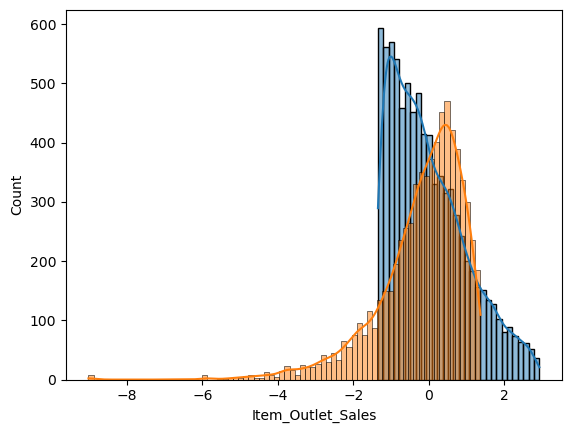

In [85]:
# Investigate the distribution of 'Item_Outlet_Sales'
sns.histplot(data['Item_Outlet_Sales'], kde=True)

# Apply log transformation to address skewness
data['Item_Outlet_Sales_Log'] = np.log1p(data['Item_Outlet_Sales'])

# Check distribution after transformation
sns.histplot(data['Item_Outlet_Sales_Log'], kde=True)

In [87]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [89]:
df_encoded

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,156,9.300,0.016047,249.8092,9,1999,3735.1380
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,8,5.920,0.019278,48.2692,3,2009,443.4228
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,662,17.500,0.016760,141.6180,9,1999,2097.2700
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1121,19.200,0.000000,182.0950,0,1998,732.3800
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1297,8.930,0.000000,53.8614,1,1987,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,370,6.865,0.056783,214.5218,1,1987,2778.3834
8519,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,897,8.380,0.046982,108.1570,7,2002,549.2850
8520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1357,10.600,0.035186,85.1224,6,2004,1193.1136
8521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,681,7.210,0.145221,103.1332,3,2009,1845.5976


In [95]:
df_encoded.dtypes

Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Househol                 float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drink               float64
Item_Type_Starchy Foods            float64
Outlet_Location_Type_Tier 1        float64
Outlet_Location_Type_Tier 2        float64
Outlet_Location_Type_Tier 3        float64
Outlet_Type_Grocery Store          float64
Outlet_Type_Supermarket Type1      float64
Outlet_Type